# Open Context Zooarchaeology Measurements

This code gets meaurement data from Open Context to hopefully do some interesting things.

In [2]:
import requests
import numpy as np
import matplotlib.pyplot as plt
from time import sleep

class OpenContextAPI():
    """ Interacts with the Open Context API
        to get lists of records for analysis
        
        See API documentation here: https://opencontext.org/about/services
    """
    RECS_PER_REQUEST = 200  # number of records to retrieve per request
    FLATTEN_ATTRIBUTES = False  # make sure attributes are single value, not lists
    RESPONSE_TYPE_LIST = ['metadata', 'uri-meta']
    SLEEP_TIME = .35  # seconds to pause between requests

    def __init__(self):
        self.recs_per_request = self.RECS_PER_REQUEST
        self.sleep_time = self.SLEEP_TIME
        self.flatten_attributes = self.FLATTEN_ATTRIBUTES
        self.response_types = self.RESPONSE_TYPE_LIST
        self.add_standard_num_attribs = True  # automatically add standard numeric attributes to records
        self.attribute_slugs = []  # slug identifiers of additional attributes to include with records
        self.attribute_labels = []
    
    def get_selection_attributes(self, url):
        """ Each Open Context query selects records described by a
            different set of attributes.
            
            This method finds the numeric and general 
            gets attributes available for an Open Context search
        """
        headers = {
            'accept': 'application/json'
        }
        json_data = None
        try:
            sleep(self.sleep_time)  # pause to not overwhelm the API
            print('GET attributes for: ' + url)
            r = requests.get(url, headers=headers)
            r.raise_for_status()
            json_data = r.json()
        except:
            raise('Request fail at: ' + url)
            json_data = None
        if json_data is not None:
            if 'oc-api:has-facets' in json_data:
                for facet in json_data['oc-api:has-facets']:
                    if self.add_standard_num_attribs:
                        if 'rdfs:isDefinedBy' in facet:
                            if 'opencontext.org/vocabularies/' in facet['rdfs:isDefinedBy']:
                                # a facet option defined as part of an Open Context vocabulary
                                # this would have standard numeric attributes
                                if 'oc-api:has-numeric-options' in facet:
                                    for f_opt in facet['oc-api:has-numeric-options']:
                                        slug = f_opt['slug']
                                        label = f_opt['label']
                                        if slug not in self.attribute_slugs:
                                            # add the numeric attribute slug
                                            self.attribute_slugs.append(slug)
                                            if label not in self.attribute_labels:
                                                self.attribute_labels.append(label)
                                            else:
                                                label = label + '[' + slug + ']'
                                                self.attribute_labels.append(label)
    
    
    def get_paged_json_records(self, url, do_paging=True):
        """ gets data from a URL, and follows the next page
           link if "do_paging" is True
        """
        records = []
        headers = {
            'accept': 'application/json'
        }
        json_data = None
        add_params = False 
        params = {}
        params['rows'] = self.recs_per_request
        if len(self.attribute_slugs) > 0:
            params['attributes'] = ','.join(self.attribute_slugs)
        if len(self.response_types) > 0:
            params['response'] = ','.join(self.response_types)
        if self.flatten_attributes:
            params['flatten-attributes'] = 1
        for key, val in params.items():
            if (key + '=') not in url:
                add_params = True
        try:
            sleep(self.sleep_time)  # pause to not overwhelm the API
            print('GET: ' + url)
            if add_params:
                # we need to add request parameters
                r = requests.get(url, params=params, headers=headers)
            else:
                # the parameters are already in the URL
                r = requests.get(url, headers=headers)
            r.raise_for_status()
            json_data = r.json()
        except:
            raise('Request fail at: ' + url)
            json_data = None
        if json_data is not None:
            # successful request
            if 'oc-api:has-results' in json_data:
                # add the new records to the result
                records += json_data['oc-api:has-results']
            if 'next' in json_data and do_paging:
                new_url = json_data['next']
                if isinstance(new_url, str):
                    # recursively get the next page of results
                    records += self.get_paged_json_records(new_url, do_paging)
        return records

    
class OpenContextPlot():
    """ Plots the Open Context data """
    def __init__(self):
        self.key_x_axis = None
        self.key_y_axis = None
        self.key_type = None
        self.x_min_ok = None
        self.x_max_ok = None
        self.y_min_ok = None
        self.y_max_ok = None
        self.markers = [
            'o',
            'x',
            'v',
            'D',
            'p',
            '^',
            's',
            '*'
        ]

    def make_records_scatter_plot(self, records):
        """ makes a scatter plot of records """
        types_data = {}
        for rec in records:
            act_x = self.get_validate_numval_by_key(self.key_x_axis,
                                                    rec,
                                                    self.x_min_ok,
                                                    self.x_max_ok)
            act_y = self.get_validate_numval_by_key(self.key_y_axis,
                                                    rec,
                                                    self.y_min_ok,
                                                    self.y_max_ok)
            act_type = self.get_rec_value_by_key(self.key_type, rec)
            if act_x is not None \
               and act_y is not None \
               and act_type is not None:
                if act_type not in types_data:
                    next_marker_index = len(types_data)
                    if next_marker_index < len(self.markers):
                        # use the next marer on the list
                        act_marker = self.markers[next_marker_index]
                    else:
                        # we ran out of markers, so use the last one
                        act_marker = self.markers[-1]
                    type_data = {
                        'x': [],
                        'y': [],
                        'marker': act_marker,
                        'label': act_type,
                    }
                else:
                    type_data = types_data[act_type]
                type_data['x'].append(act_x)
                type_data['y'].append(act_y)
                types_data[act_type] = type_data
        leg_handles = []
        for type_key, type_data in types_data.items():
            x = np.array(type_data['x'])
            y = np.array(type_data['y'])
            leg_label = type_data['label'] + ' [n = ' + str(len(type_data['x'])) + ']'
            handle = plt.scatter(x, y, marker=type_data['marker'], label=leg_label)
            leg_handles.append(handle)
        plt.legend(handles=leg_handles, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.xlabel(self.key_x_axis)
        plt.ylabel(self.key_y_axis)
        plt.show()
    
    def get_validate_numval_by_key(self, key, rec, min_ok=None, max_ok=None):
        """ gets and validates a numeric value from a record by a key
            returns None if it doesn't exist or is not valid
        """
        value = self.get_rec_value_by_key(key, rec)
        if value is not None:
            # found a value, make sure its an OK number
            value = self.validate_numeric(value, min_ok, max_ok)
        return value
    
    def get_rec_value_by_key(self, key, rec):
        """ gets a value for a key from a record,
            handling either list or not
        """
        value = None
        if key in rec:
            if isinstance(rec[key], list):
                # we have a list, so choose the first item
                value = rec[key][0]
            else:
                value = rec[key]
        return value
    
    def validate_numeric(self, test_val, min_ok=None, max_ok=None):
        """ checks to see if a number really is a number
            and optionally if it lies between an allowed range
            of min_ok and max_ok
        """
        value = None
        try:
            value = float(test_val)
        except:
            value = None
        if value is not None:
            if min_ok is not None:
                if value < min_ok:
                    # less than minimum limit
                    value = None
            if max_ok is not None:
                if value > max_ok:
                    # greater than max limit
                    value = None
        return value
        

GET attributes for: https://opencontext.org/subjects-search/?prop=biol-term-hastaxonomy---eol-p-1---eol-p-1642---eol-p-7678&prop=oc-zoo-has-anat-id---obo-uberon-0013588&prop=oc-zoo-anatomical-meas---oc-zoo-von-den-driesch-bone-meas
GET: https://opencontext.org/subjects-search/?prop=biol-term-hastaxonomy---eol-p-1---eol-p-1642---eol-p-7678&prop=oc-zoo-has-anat-id---obo-uberon-0013588&prop=oc-zoo-anatomical-meas---oc-zoo-von-den-driesch-bone-meas
GET: https://opencontext.org/subjects-search/?response=metadata%2Curi-meta&prop=biol-term-hastaxonomy---eol-p-1---eol-p-1642---eol-p-7678&prop=oc-zoo-has-anat-id---obo-uberon-0013588&prop=oc-zoo-anatomical-meas---oc-zoo-von-den-driesch-bone-meas&start=200&rows=200&attributes=oc-zoo-bd%2Coc-zoo-bp%2Coc-zoo-dd%2Coc-zoo-dp%2Coc-zoo-bfd%2Coc-zoo-sd%2Coc-zoo-gl%2Coc-zoo-dd-2%2Coc-zoo-lep%2Coc-zoo-ll%2Coc-zoo-ld%2Coc-zoo-cd%2Coc-zoo-slc%2Coc-zoo-gb%2Coc-zoo-gll
GET: https://opencontext.org/subjects-search/?response=metadata%2Curi-meta&prop=biol-term-h

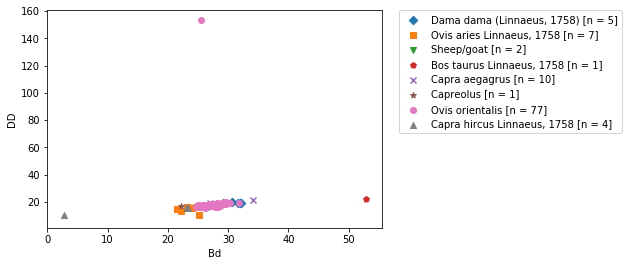

In [3]:
url = 'https://opencontext.org/subjects-search/?prop=biol-term-hastaxonomy---eol-p-1---eol-p-1642---eol-p-7678&prop=oc-zoo-has-anat-id---obo-uberon-0013588&prop=oc-zoo-anatomical-meas---oc-zoo-von-den-driesch-bone-meas'
oc_api = OpenContextAPI()
oc_plt = OpenContextPlot()
oc_api.get_selection_attributes(url)
records = oc_api.get_paged_json_records(url)
print('Number of records: ' + str(len(records)))
oc_plt.key_x_axis = 'Bd'
oc_plt.key_y_axis = 'DD'
oc_plt.key_type = 'Has Biological Taxonomy'
oc_plt.make_records_scatter_plot(records)

## Now remove some of the outliers
We probably have some measurement and/or recording errors. The "y_max_ok" attribute is the
maximum value for y ("DD") values that we'll accept for plotting.

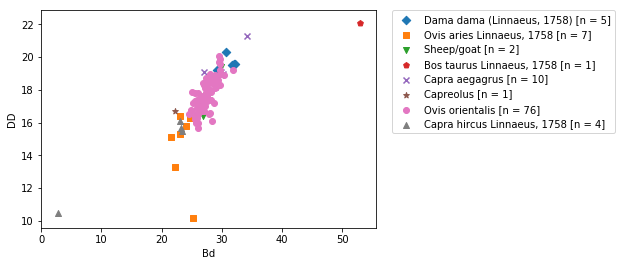

In [5]:
oc_plt = OpenContextPlot()
oc_plt.key_x_axis = 'Bd'
oc_plt.key_y_axis = 'DD'
oc_plt.key_type = 'Has Biological Taxonomy'
oc_plt.y_max_ok = 40
oc_plt.make_records_scatter_plot(records)
